In [1]:
import numpy as np, os, sys
sys.path.append("..")
import wandb

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data
from src.models import DeepBindCNN
from src.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve
from src.utils import metrics
import torchmetrics

import matplotlib as mpl 
from matplotlib import pyplot as plt 
%matplotlib inline

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kumarh/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/kumarh/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# get data 
savedir = "./data"
# _=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 60,
    "patience": 5,
    }

In [5]:
WANDB= False
if WANDB:

    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="deepbind_synthetic_aug3",

        # track hyperparameters and run metadata
        config=config
    )

In [6]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'])

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid', 'test']}
print(dataset_sizes)

# Iterate through the dataset to count class occurrences
labels = set()
for j in ['train', 'valid', 'test']:
    class_counts = {0: 0, 1: 0}  # Assuming binary classification
    for sequence, label in datasets[j]:
        class_counts[int(label)] += 1

    # Print the class counts
    for class_label, count in class_counts.items():
        print(f"{j} class {class_label}: {count} samples")


{'train': 14000, 'valid': 2000, 'test': 4000}
train class 0: 6994 samples
train class 1: 7006 samples
valid class 0: 1021 samples
valid class 1: 979 samples
test class 0: 1985 samples
test class 1: 2015 samples


In [7]:
# set up the model, lossfn, optimizer, trainer 
model = DeepBindCNN(input_size=4, output_size=1, kernel_size=9)
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
metrics_list = [getattr(metrics, met) for met in ['accuracy', 'auroc']]
trainer = Trainer(model, lossfn, optimizer, metrics=metrics_list, wandb=False)

history = trainer.fit(
            loaders['train'], 
            val_loader=loaders['valid'], 
            nepochs=config['epochs'], 
            patience=config['patience'],
            save_path='deepbind_best_model.pt'
                    )

Model saved at epoch 1, val_loss: inf -> 0.6442
Epoch:   1/60, loss: 0.6732, accuracy: 0.6172, auroc: 0.7371, val_loss: 0.6442, val_accuracy: 0.6890, val_auroc: 0.7774
Model saved at epoch 2, val_loss: 0.6442 -> 0.5938
Epoch:   2/60, loss: 0.6169, accuracy: 0.6941, auroc: 0.7726, val_loss: 0.5938, val_accuracy: 0.7014, val_auroc: 0.7776
Model saved at epoch 3, val_loss: 0.5938 -> 0.5749
Epoch:   3/60, loss: 0.5864, accuracy: 0.6993, auroc: 0.7730, val_loss: 0.5749, val_accuracy: 0.7049, val_auroc: 0.7778
Model saved at epoch 4, val_loss: 0.5749 -> 0.5678
Epoch:   4/60, loss: 0.5763, accuracy: 0.7026, auroc: 0.7740, val_loss: 0.5678, val_accuracy: 0.7083, val_auroc: 0.7792
Model saved at epoch 5, val_loss: 0.5678 -> 0.5643
Epoch:   5/60, loss: 0.5723, accuracy: 0.7033, auroc: 0.7753, val_loss: 0.5643, val_accuracy: 0.7108, val_auroc: 0.7801
Model saved at epoch 6, val_loss: 0.5643 -> 0.5620
Epoch:   6/60, loss: 0.5701, accuracy: 0.7053, auroc: 0.7767, val_loss: 0.5620, val_accuracy: 0.7

In [13]:
model.load_state_dict(torch.load("deepbind_best_model.pt"));

In [26]:
model = model.to("cpu")
ytest, ytestpred = [], []
running_corrects = 0
for batch in loaders['test']:
    xtest, _ytest = batch
    ytest.append(_ytest)
    ytestpred.append(model(xtest))
    predicted_probs = torch.sigmoid(model(xtest).detach().squeeze())
    predicted_classes = (predicted_probs > 0.5).float()
    running_corrects += torch.sum(predicted_classes == _ytest.data)

epoch_acc = running_corrects.double() / dataset_sizes['test']
print(epoch_acc.item())

0.7635


In [15]:
history.keys()

dict_keys(['loss', 'accuracy', 'auroc', 'val_loss', 'val_accuracy', 'val_auroc'])

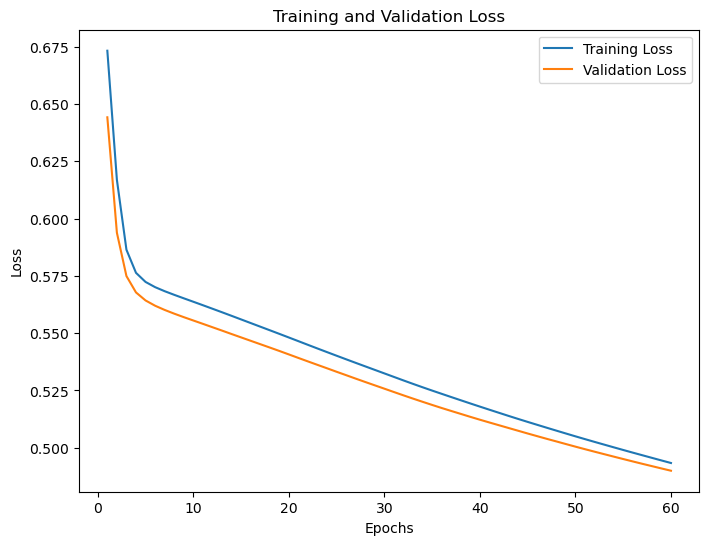

In [16]:
# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.8402


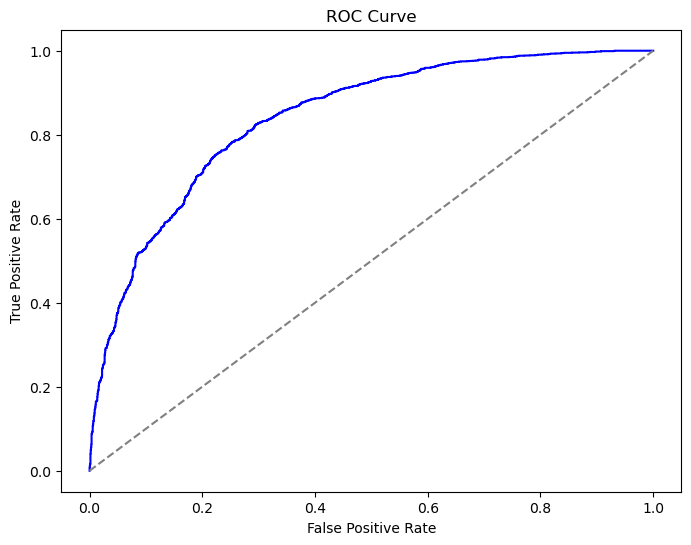

In [17]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [14]:
wandb.finish()